引用：https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes

# Importing Libraries

In [1]:
import os
import cv2
import csv
import glob
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

在这个内核中，提供了一些实用函数来对图像进行全面检查，以及一些函数，用于网格中绘制多个图像时，可以在将来的项目中重用这些函数。
#### references
[Paperspace DataAugmentationForObjectDetection](https://github.com/Paperspace/DataAugmentationForObjectDetection)
[ateplyuk's gwd starter](https://www.kaggle.com/ateplyuk/gwd-starter-efficientdet-train)

## Utilities
实用函数存储在这里，它们非常有用，可以随意将它们添加到您的库中。


In [2]:
def skip_csv_header(file):
    has_header = csv.Sniffer().has_header(file.read(1024))
    file.seek(0)
    if has_header:
        next(file)


def total_image_list(image_folder_path):
    total_img_list = [os.path.basename(img_path_name) for img_path_name in glob.glob(os.path.join(image_folder_path, "*.jpg"))]
    return total_img_list

def draw_rect(img, bboxes, color=None):
    img = img.copy()
    bboxes = bboxes[:, :4]
    bboxes = bboxes.reshape(-1, 4)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=ceil(len(img_matrix_list) / ncols), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

### Reading and Loading the Dataset

In [3]:
train = pd.read_csv("./dataset/global-wheat-detection/train.csv")  
image_folder_path = "./dataset/global-wheat-detection/train/"



I personally like to expand the bounding box coordinates into the form of x_min, y_min, x_max, y_max, but currently they are stored in a list of [x_min,y_min, width of bbox, height of bbox]. So the next portion will help to expand them out. This is a personal preference, in actual fact you do not need to do this, it is easier for me to normalize the bboxes

In [4]:
train['bbox'] = train['bbox'].apply(lambda x: x[1:-1].split(","))
train['x_min'] = train['bbox'].apply(lambda x: x[0]).astype('float32')
train['y_min'] = train['bbox'].apply(lambda x: x[1]).astype('float32')
train['width'] = train['bbox'].apply(lambda x: x[2]).astype('float32')
train['height'] = train['bbox'].apply(lambda x: x[3]).astype('float32')
train = train[['image_id','x_min', 'y_min', 'width', 'height']]
train["x_max"] = train.apply(lambda col: col.x_min + col.width, axis=1)
train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis = 1)
train.head()

image_id  x_min  y_min  width  height  x_max  y_max
0  b6ab77fd7  834.0  222.0   56.0    36.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  130.0    58.0  356.0  606.0
2  b6ab77fd7  377.0  504.0   74.0   160.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  109.0   107.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  124.0   117.0  150.0  261.0

### Range Checking on Bounding Box Coordinates
此外，由于python内部的浮动问题，x_max和y_max中可能会有一些奇怪的值，比如负值或值加起来超过1024。这里我们要小心。
这是一个严重的问题，当你正则化边界框，它可能会超过1，这将导致错误，特别是如果你决定增益图像。


In [5]:
train[train["x_max"] > 1024]
train[train["y_max"] > 1024]
train[train["x_min"] < 0]
train[train["y_min"] < 0]

image_id       x_min  y_min       width      height        x_max  \
31785  fda86ae9a  873.200012   10.4  150.800003  186.000000  1024.000015   
61189  b70c20580  994.400024  770.0   29.600000   29.799999  1024.000025   

            y_max  
31785  196.400000  
61189  799.799999

image_id       x_min       y_min      width      height       x_max  \
43087  da5063a1b  464.799988  894.400024  58.200001  129.600006  522.999989   

             y_max  
43087  1024.000031

Empty DataFrame
Columns: [image_id, x_min, y_min, width, height, x_max, y_max]
Index: []

Empty DataFrame
Columns: [image_id, x_min, y_min, width, height, x_max, y_max]
Index: []

对于大于1024的唯一原因是原始数据集的标记问题。让我们看看各自的问题行。例如，在第31785行中，提供的x_min是873.200012，当您将其添加到宽度为150.800003时，将得到1024.000015，这已经超过了图像的大小。所以要四舍五入。在我看来，当非规格化时，边界框应该是整数。但这只是我的看法。让我们将这些有问题的值更改为1024

In [6]:
x_max = np.array(train["x_max"].values.tolist())
y_max = np.array(train["y_max"].values.tolist())
train["x_max"] = np.where(x_max > 1024, 1024, x_max).tolist()
train["y_max"] = np.where(y_max > 1024, 1024, y_max).tolist()

我们可以删除宽度和高度列，因为我们不需要它们，它可以很容易地从图像提取出来。

In [7]:
del train["width"]
del train["height"]
train.head()

image_id  x_min  y_min  x_max  y_max
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0

我指定了一个类“1”，它是小麦标签。如果我们希望在图像中添加没有小麦的图像，那么以后它可能会有用。

In [8]:
train["class"] = "1"
train.head()

image_id  x_min  y_min  x_max  y_max class
0  b6ab77fd7  834.0  222.0  890.0  258.0     1
1  b6ab77fd7  226.0  548.0  356.0  606.0     1
2  b6ab77fd7  377.0  504.0  451.0  664.0     1
3  b6ab77fd7  834.0   95.0  943.0  202.0     1
4  b6ab77fd7   26.0  144.0  150.0  261.0     1

### Check if image extensions are all jpg
首先，检查训练文件夹中的所有图像是否都是.jpg格式。最好检查一下，因为如果有混合的图像类型，我们以后可能会遇到麻烦。

In [9]:
def check_file_type(image_folder_path):
    extension_type = []
    file_list = os.listdir(image_folder_path)
    for file in file_list:
        extension_type.append(file.rsplit(".", 1)[1].lower())
    print(Counter(extension_type).keys())
    print(Counter(extension_type).values())
    
check_file_type(image_folder_path)

dict_keys(['jpg'])
dict_values([3422])


检查结果显示文件夹里的所有图片都是.jpg格式的。接下来，最好在dataframe中的所有image_id后面追加.jpg。以便之后更容易地操作数据。

In [10]:
## replace image_id with .jpg behind the image_id
# image_id_list = train["image_id"].tolist()
# image_id_append_jpg = []
# for image_id in image_id_list:
#     image_id_append_jpg.append(image_id + ".jpg")
# train["image_id"] = image_id_append_jpg
# train.head()


## Alternatively like Rohit suggested, an one liner will do the trick

train["image_id"] = train["image_id"].apply(lambda x: str(x) + ".jpg")
train.head()

image_id  x_min  y_min  x_max  y_max class
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0     1
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0     1
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0     1
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0     1
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0     1

In [11]:
train["image_id"] = train["image_id"].astype("str")

In [12]:
train.to_csv("wheat.csv", index=False)

## 检查是否有损坏的图像和是否所有的图像是1024×1024
大部分的人都会使用df['width'].unique() == df['height'].unique() == [1024]去检查是否所有的图像都是1024x1024的像素。但是我们并不百分百确定是否在训练文件夹中是正确的。所以这里不使用同样的方法。

In [13]:
def check_image_size(image_folder_path):
    total_img_list = glob.glob(os.path.join(image_folder_path,"*"))
    counter = 0
    for image in tqdm(total_img_list, desc = "Checking in progress"):
        try:
            img = cv2.imread(image)
            height, width = img.shape[1], img.shape[0]
            if not (height == 1024 and width == 1024):
                counter = counter + 1
        except:
            print("This {} is problematic.".format(image))
    return counter 

In [14]:
check_image_size(image_folder_path)

0

结果显示，所有的图片都是1024x1024的尺寸。好的方面是，这段代码还帮助我们检查损坏的图像，如果有损坏的图像，它肯定会显示计数器是非零的。从那里你可以进一步检查哪个图像是导致问题的。

## train.csv和训练图像之间的完整性检查  
我们将编写一个函数来检查唯一image_id的数量是否与文件夹中唯一图像的数量匹配。

In [19]:
## our new dataset
wheat = pd.read_csv("wheat.csv") 
image_folder_path = "./dataset/global-wheat-detection/train/"
image_annotation_file = "wheat.csv"

In [20]:
wheat.head()

image_id  x_min  y_min  x_max  y_max  class
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0      1
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0      1
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0      1
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0      1
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0      1

In [21]:
def sanity_tally(image_folder_path, image_annotation_file):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")
        
    img_annotation_list = [*img_dict]
    total_img_list = total_image_list(image_folder_path)
    if set(img_annotation_list) == set(total_img_list):
        print("Sanity Check Status: True")
    else:
        print("Sanity Check Status: Failed. \nThe elements in wheat/train.csv but not in the train image folder is {}. \nThe elements in train image folder but not in wheat/train.csv is {}".format(
                set(img_annotation_list) - set(total_img_list), set(total_img_list) - set(img_annotation_list)))
        return list(set(img_annotation_list) - set(total_img_list)), list(set(total_img_list) - set(img_annotation_list))

In [22]:
set_diff1, set_diff2 = sanity_tally(image_folder_path, image_annotation_file = image_annotation_file)
print("There are {} images without annotations in the train/wheat.csv".format(len(set_diff2)))

Sanity Check Status: Failed. 
The elements in wheat/train.csv but not in the train image folder is set(). 
The elements in train image folder but not in wheat/train.csv is {'3116768f0.jpg', '0e7832f0b.jpg', '8a5cb62db.jpg', '8de789df8.jpg', 'ffbb9c623.jpg', '65d0b13aa.jpg', 'ed00a614d.jpg', 'd7e657453.jpg', 'f9cafa47f.jpg', 'de2a3cf37.jpg', 'dec23c826.jpg', '46c6a747a.jpg', '952e7d15c.jpg', 'dd5d2fa9e.jpg', 'f2a6804d2.jpg', '7e1caf1f7.jpg', '8425a537b.jpg', 'b45c5294d.jpg', 'd771bb084.jpg', 'f530a5d4b.jpg', '91d4e3750.jpg', 'a3ce975cd.jpg', '69352f3fa.jpg', '2d80f9c49.jpg', 'd83808467.jpg', '0cf7ef43d.jpg', '581eaf87b.jpg', '39a0e5556.jpg', 'c74ca81bd.jpg', '1a9792bfc.jpg', '5cbd092f9.jpg', '526d737d1.jpg', 'cf1d2f504.jpg', '5901a73fe.jpg', '83a94fc79.jpg', 'ec196d18a.jpg', 'c18c32da0.jpg', '49e40c7a4.jpg', 'cfc9040ca.jpg', 'ab20ec355.jpg', '2e6c333a7.jpg', '155c440e8.jpg', '00b5c6764.jpg', '6584c18c0.jpg', 'ccb3892c1.jpg', 'e4ec17f9b.jpg', '45fddc611.jpg', '9e21e7969.jpg', 'e01ad95cf.

如上所示，共有49张图像由于没有包含小麦所有没有bbox标注，因此也就没有出现在train.csv。我们可以将这49个图像放到train.csv中，并将它们标记为0。


## Plotting Multiple Images
在这里，我们定义了一个很好的函数，它不仅对这个竞赛有用，而且对类似的项目也有用。注意，我们在这里使用了功能函数来绘制它们。可以相应地调整参数。


In [23]:
def plot_random_images(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 images to plot
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        img_matrix_list.append(img)

    
    return plot_multiple_img(img_matrix_list, title_list = img_files_list, ncols = 4, main_title="Wheat Images")


Here we see a nice grid of 12 images plotted.

The images' names are ['6e58d4ea0.jpg' 'beacc5971.jpg' 'da8c686cb.jpg' 'c52f29668.jpg'
 '4972b9493.jpg' '93648317d.jpg' '901e23e9b.jpg' '56f7dc978.jpg'
 '768b0256e.jpg' '744ea960b.jpg' '966c3ebc6.jpg' 'b3c96d5ad.jpg']


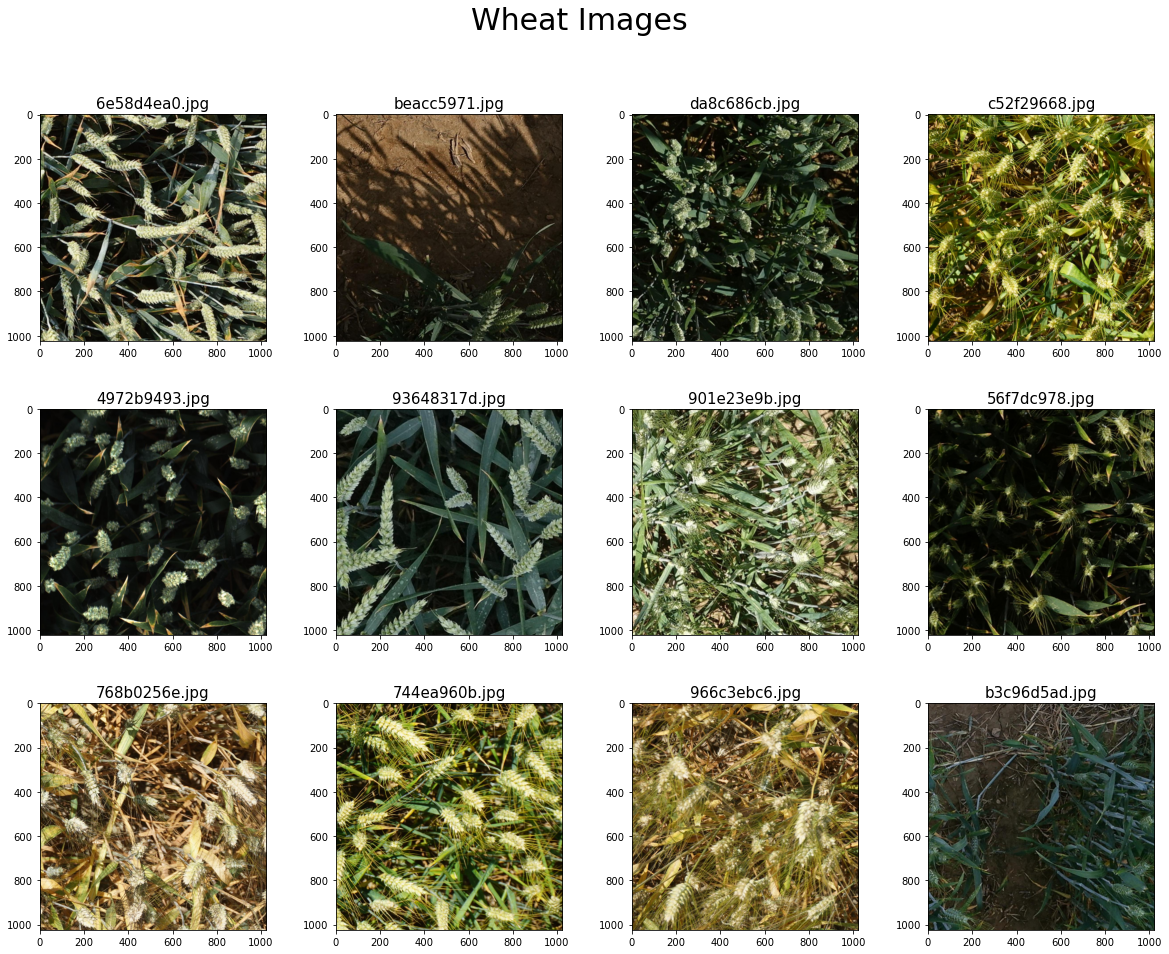

In [24]:
plot_random_images(image_folder_path, image_annotation_file, num = 12)

## Plotting Multiples Images with Bounding Boxes
在有边界框的对象检测中，随机绘制一些带有边界框的图像来检查任何扭曲的边界框坐标总是一个好主意。尽管我不得不说，在这个特殊的比赛中，有相当多的图像与许多边界框，因此你必须仔细检查清楚。

In [25]:
def random_bbox_check(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    labels = ["wheat", "no wheat"]
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 image.
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    image_file_path_list = []

    bbox_list = []
    img_matrix_list = []
    random_image_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        height, width, channels = img.shape
        bbox_list.append(img_dict[img_file])
        img_matrix_list.append(img)

    
    final_bbox_list = []
    for bboxes, img in zip(bbox_list, img_matrix_list):
        final_bbox_array = np.array([])
        #bboxes is a 2d array [[...], [...]]
        for bbox in bboxes:
            bbox = np.array(bbox).reshape(1,5)
            final_bbox_array = np.append(final_bbox_array, bbox)
        final_bbox_array = final_bbox_array.reshape(-1,5)
        random_image = draw_rect(img.copy(), final_bbox_array.copy(), color = (255,0,0))
        random_image_matrix_list.append(random_image)
    plot_multiple_img(random_image_matrix_list, title_list = img_files_list, ncols = 4, main_title="Bounding Box Wheat Images") 

The images' names are ['d15018a92.jpg' '52a0abc4b.jpg' '452fe4932.jpg' 'f985e704d.jpg'
 'eddff557c.jpg' '7ab4f3778.jpg' '29a85cd12.jpg' '5a155e612.jpg'
 '8ca10d124.jpg' 'c02bfe3f2.jpg' '79964dffd.jpg' '4311e0c38.jpg']


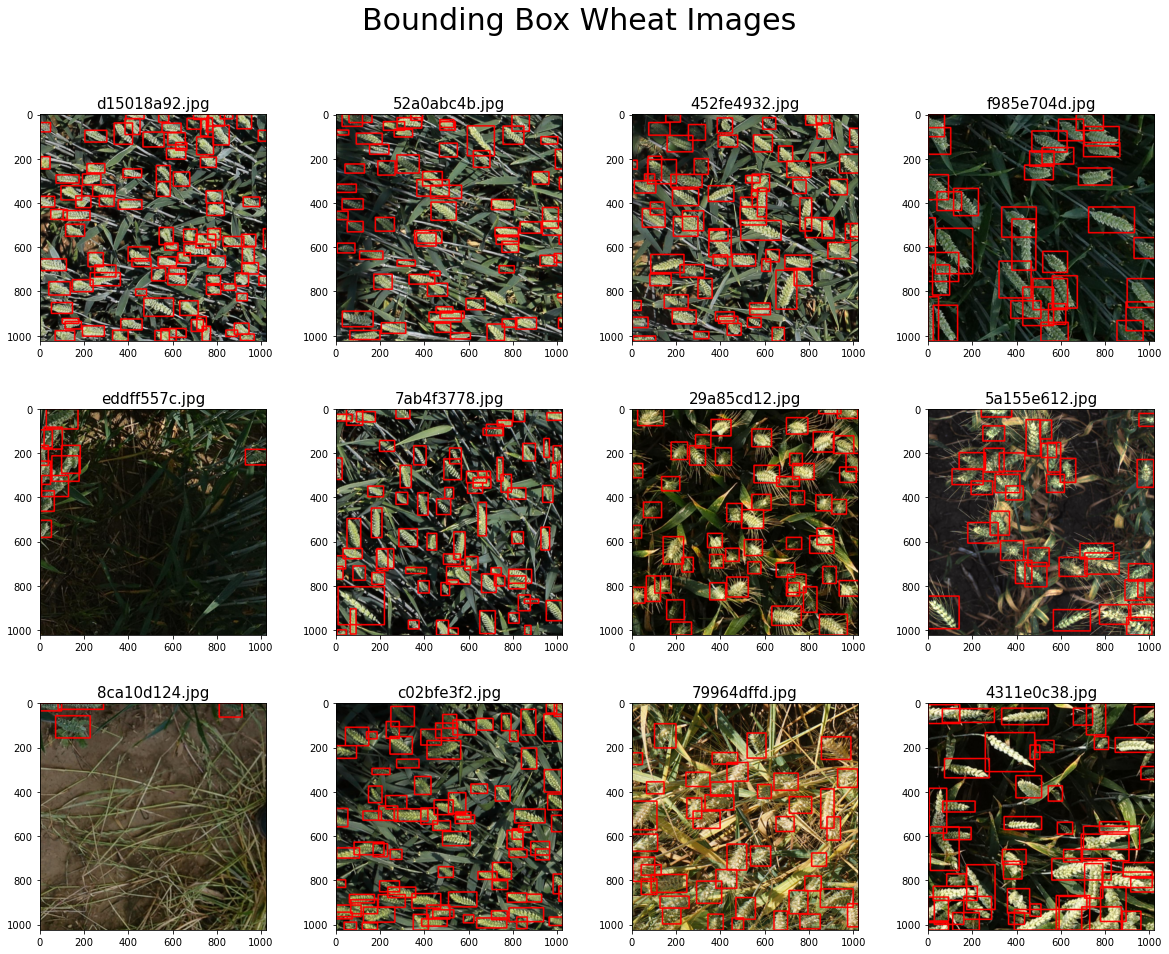

In [26]:
random_bbox_check(image_folder_path, image_annotation_file)

## Augmentations
增益是人工增加数据大小的一项重要技术。特别地，当数据集很小时，在训练模型之前的增强将帮助网络更好地学习。

In [28]:
# Albumentations
import albumentations as A

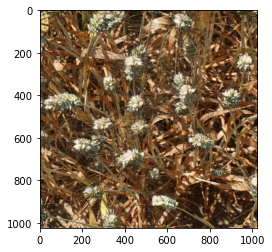

In [30]:
image_folder_path = "./dataset/global-wheat-detection/train/"
# chosen_image = cv2.imread(os.path.join(image_folder_path, "8c05f24c4.jpg"))[:,:,::-1]
chosen_image = cv2.imread(os.path.join(image_folder_path, "3f5b4ef85.jpg"))[:,:,::-1]
plt.imshow(chosen_image)

如果您只对某个图像的边框图感兴趣，则可以首先提取所选图像的dataframe，并将该图像的边框转换为2d数组。然后将draw_rect函数应用于绘图。

In [31]:
chosen_image_dataframe = wheat.loc[wheat["image_id"]=="3f5b4ef85.jpg",["x_min","y_min","x_max","y_max","class"]]
bbox_array_of_chosen_image = np.array(chosen_image_dataframe.values.tolist())
bbox_array_of_chosen_image.shape

(29, 5)

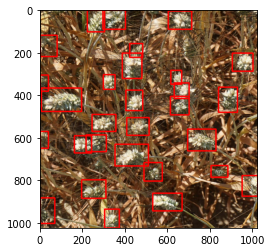

In [32]:
draw_chosen_image = draw_rect(chosen_image.copy(), bbox_array_of_chosen_image.copy(), color = (255,0,0))
plt.imshow(draw_chosen_image)

下面是一些你可以使用的增强类型的片段，有趣的是，Albumentation提供RandomSunFlare，RandomFog和RandomSnow;虽然所有的照片看起来都是在很好的光照下拍摄的，但这可能不是一个坏主意，因为在现实世界中，小麦的照片可能是在不同的天气条件下拍摄的。
